# Alcohol Detection With EEG Signals using Standard Deviation

In [1]:
import numpy as np 
import pandas as pd 
import os
import glob
from matplotlib import pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd 
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
import seaborn as sns
from sklearn.metrics import confusion_matrix

from scipy.special import entr
from scipy.stats import entropy

from sklearn.model_selection import KFold
from keras.optimizers import Adam

## Preprocess

In [2]:
_dfs_list = []
for csv_filename in os.listdir("C:/Users/fatih/Downloads/data/SMNI_CMI_TRAIN"):
    if 'csv' in csv_filename:
        _dfs_list.append(pd.read_csv(f'C:/Users/fatih/Downloads/data/SMNI_CMI_TRAIN/{csv_filename}'))
df = pd.concat(_dfs_list)
del(_dfs_list)
df = df.drop(['Unnamed: 0'], axis=1)
df.head(3)

,trial number,sensor position,sample num,sensor value,subject identifier,matching condition,channel,name,time
0,0,FP1,0,-8.921,a,S1 obj,0,co2a0000364,0.000000
1,0,FP1,1,-8.433,a,S1 obj,0,co2a0000364,0.003906
2,0,FP1,2,-2.574,a,S1 obj,0,co2a0000364,0.007812


In [3]:
si_list = list(set(df['subject identifier']))
si_list.sort()

si_mapping = {
    'a': 1,
    'c' : 0
}

si_mapping_full = dict()

for ch in si_list:
    if ch in si_mapping:
        si_mapping_full[ch] = si_mapping[ch]
    else:
        si_mapping_full[ch] = ch

channel_list_fixed = [si_mapping_full[ch] for ch in si_list]
        
df['subject_identifier'] = df['subject identifier'].map(si_mapping_full)
df.head(3)

,trial number,sensor position,sample num,sensor value,subject identifier,matching condition,channel,name,time,subject_identifier
0,0,FP1,0,-8.921,a,S1 obj,0,co2a0000364,0.000000,1
1,0,FP1,1,-8.433,a,S1 obj,0,co2a0000364,0.003906,1
2,0,FP1,2,-2.574,a,S1 obj,0,co2a0000364,0.007812,1


In [4]:
pos_name = {}
idx = 0
for csv_filename in os.listdir("C:/Users/fatih/Downloads/data/SMNI_CMI_TRAIN"):
    if 'csv' in csv_filename:
        trial_num = pd.read_csv(f'C:/Users/fatih/Downloads/data/SMNI_CMI_TRAIN/{csv_filename}')['trial number'][0]
        name = pd.read_csv(f'C:/Users/fatih/Downloads/data/SMNI_CMI_TRAIN/{csv_filename}')['name'][0]
        label = pd.read_csv(f'C:/Users/fatih/Downloads/data/SMNI_CMI_TRAIN/{csv_filename}')['subject identifier'][0]
        pos_name[idx] = [name, trial_num, label]
        idx +=1

In [5]:
sensor_positions = df['sensor position'].values
names = df['name'].values
trial_numbers = df['trial number'].values
sensor_values = df['sensor value'].values
label_values = df['subject_identifier'].values

In [6]:
full_data = {}
labels = []

for i in pos_name:
    name = pos_name[i][0]
    trial_num = pos_name[i][1]
    label = 1 if pos_name[i][2] == 'a' else 0

    mask_gen = (df['name'] == name) & (df['trial number'] == trial_num)
    filtered_df = df[mask_gen]

    sensor_entropy = filtered_df.groupby('sensor position')['sensor value'].apply(lambda x: np.std(x)).to_dict()

    labels.append(label)
    print(f'{i} -> {name}, {trial_num}, {label}')
    
    full_data[f'{name},{trial_num}'] = sensor_entropy

input_data = pd.DataFrame.from_dict(full_data).T
input_target = pd.DataFrame(labels).values

0 -> co2a0000364, 0, 1
1 -> co2a0000364, 18, 1
2 -> co2a0000369, 13, 1
3 -> co2a0000369, 14, 1
4 -> co2a0000369, 15, 1
5 -> co2a0000369, 16, 1
6 -> co2a0000369, 17, 1
7 -> co2a0000369, 18, 1
8 -> co2a0000369, 19, 1
9 -> co2a0000369, 21, 1
10 -> co2a0000369, 23, 1
11 -> co2a0000369, 25, 1
12 -> co2a0000364, 19, 1
13 -> co2a0000369, 27, 1
14 -> co2a0000369, 29, 1
15 -> co2a0000369, 31, 1
16 -> co2a0000369, 33, 1
17 -> co2a0000369, 35, 1
18 -> co2a0000369, 37, 1
19 -> co2a0000369, 39, 1
20 -> co2a0000369, 41, 1
21 -> co2a0000369, 47, 1
22 -> co2a0000370, 0, 1
23 -> co2a0000364, 20, 1
24 -> co2a0000370, 2, 1
25 -> co2a0000370, 5, 1
26 -> co2a0000370, 6, 1
27 -> co2a0000370, 8, 1
28 -> co2a0000370, 9, 1
29 -> co2a0000370, 10, 1
30 -> co2a0000370, 11, 1
31 -> co2a0000370, 12, 1
32 -> co2a0000370, 13, 1
33 -> co2a0000370, 14, 1
34 -> co2a0000364, 22, 1
35 -> co2a0000370, 15, 1
36 -> co2a0000370, 16, 1
37 -> co2a0000370, 18, 1
38 -> co2a0000370, 19, 1
39 -> co2a0000370, 20, 1
40 -> co2a0000370

In [7]:
input_data = input_data.reset_index(drop=True)

### Test Set Preprocess

In [8]:
_dfs_list = []
for csv_filename in os.listdir("C:/Users/fatih/Downloads/data/SMNI_CMI_TEST"):
    if 'csv' in csv_filename:
        _dfs_list.append(pd.read_csv(f'C:/Users/fatih/Downloads/data/SMNI_CMI_TEST/{csv_filename}'))
test = pd.concat(_dfs_list)
del(_dfs_list)
test = test.drop(['Unnamed: 0'], axis=1)

si_list = list(set(test['subject identifier']))
si_list.sort()

si_mapping = {
    'a': 1,
    'c' : 0
}

si_mapping_full = dict()

for ch in si_list:
    if ch in si_mapping:
        si_mapping_full[ch] = si_mapping[ch]
    else:
        si_mapping_full[ch] = ch

channel_list_fixed = [si_mapping_full[ch] for ch in si_list]
        
test['subject_identifier'] = test['subject identifier'].map(si_mapping_full)

pos_name = {}
idx = 0

for csv_filename in os.listdir("C:/Users/fatih/Downloads/data/SMNI_CMI_TEST"):
    if 'csv' in csv_filename:
        trial_num = pd.read_csv(f'C:/Users/fatih/Downloads/data/SMNI_CMI_TEST/{csv_filename}')['trial number'][0]
        name = pd.read_csv(f'C:/Users/fatih/Downloads/data/SMNI_CMI_TEST/{csv_filename}')['name'][0]
        label = pd.read_csv(f'C:/Users/fatih/Downloads/data/SMNI_CMI_TEST/{csv_filename}')['subject identifier'][0]
        pos_name[idx] = [name, trial_num, label]
        idx +=1

def entropy1(labels, base=None):
  value,counts = np.unique(labels, return_counts=True)
  return entropy(counts, base=base)
sensor_positions = test['sensor position'].values
names = test['name'].values
trial_numbers = test['trial number'].values
sensor_values = test['sensor value'].values
label_values = test['subject_identifier'].values


full_data2 = {}
labels2 = []

for i in pos_name:
    name = pos_name[i][0]
    trial_num = pos_name[i][1]
    label = 1 if pos_name[i][2] == 'a' else 0

    mask_gen = (test['name'] == name) & (test['trial number'] == trial_num)
    filtered_test = test[mask_gen]

    sensor_entropy = filtered_test.groupby('sensor position')['sensor value'].apply(lambda x: np.std(x)).to_dict()

    labels2.append(label)
    print(f'{i} -> {name}, {trial_num}, {label}')
    
    full_data2[f'{name},{trial_num}'] = sensor_entropy

test_data = pd.DataFrame.from_dict(full_data2).T
test_target = pd.DataFrame(labels2).values


0 -> co2a0000364, 30, 1
1 -> co2a0000364, 50, 1
2 -> co2a0000369, 38, 1
3 -> co2a0000369, 43, 1
4 -> co2a0000369, 45, 1
5 -> co2a0000369, 51, 1
6 -> co2a0000369, 53, 1
7 -> co2a0000369, 55, 1
8 -> co2a0000369, 57, 1
9 -> co2a0000369, 59, 1
10 -> co2a0000369, 61, 1
11 -> co2a0000369, 63, 1
12 -> co2a0000364, 63, 1
13 -> co2a0000369, 65, 1
14 -> co2a0000369, 67, 1
15 -> co2a0000369, 71, 1
16 -> co2a0000369, 73, 1
17 -> co2a0000369, 75, 1
18 -> co2a0000369, 77, 1
19 -> co2a0000369, 81, 1
20 -> co2a0000369, 83, 1
21 -> co2a0000369, 85, 1
22 -> co2a0000369, 87, 1
23 -> co2a0000364, 65, 1
24 -> co2a0000369, 91, 1
25 -> co2a0000370, 22, 1
26 -> co2a0000370, 24, 1
27 -> co2a0000370, 26, 1
28 -> co2a0000370, 28, 1
29 -> co2a0000370, 30, 1
30 -> co2a0000370, 32, 1
31 -> co2a0000370, 34, 1
32 -> co2a0000370, 36, 1
33 -> co2a0000370, 38, 1
34 -> co2a0000364, 67, 1
35 -> co2a0000370, 39, 1
36 -> co2a0000370, 40, 1
37 -> co2a0000370, 43, 1
38 -> co2a0000370, 45, 1
39 -> co2a0000370, 49, 1
40 -> co2a

In [9]:
test_data = test_data.reset_index(drop=True)

## Training using K-fold cross validation

In [10]:
def create_model():
    model = Sequential()
    model.add(Dense(32, activation='leaky_relu', input_dim=64))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',
                  optimizer=Adam(),
                  metrics=['accuracy'])
    return model

# Set up k-fold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cvscores = []

# Perform the k-fold cross-validation
for train, test in kfold.split(input_data, input_target):

    model = create_model()
    
    # Fit the model
    hist = model.fit(input_data.T[train].T, input_target[train],
              validation_data=(input_data.T[test].T, input_target[test]),
              epochs=100,
              batch_size=64,
              verbose=0)
    
    # Evaluate the model
    scores = model.evaluate(input_data.T[test].T, input_target[test], verbose=0)
    print(f"Fold accuracy: {scores[1] * 100:.2f}%")
    cvscores.append(scores[1] * 100)

# Print the mean and standard deviation of accuracy across folds
print(f"Accuracy: {np.mean(cvscores):.2f}% (+/- {np.std(cvscores):.2f}%)")

C:\Users\fatih\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold accuracy: 78.72%


C:\Users\fatih\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold accuracy: 86.17%


C:\Users\fatih\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold accuracy: 90.43%


C:\Users\fatih\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold accuracy: 91.40%


C:\Users\fatih\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold accuracy: 84.95%
Accuracy: 86.33% (+/- 4.52%)


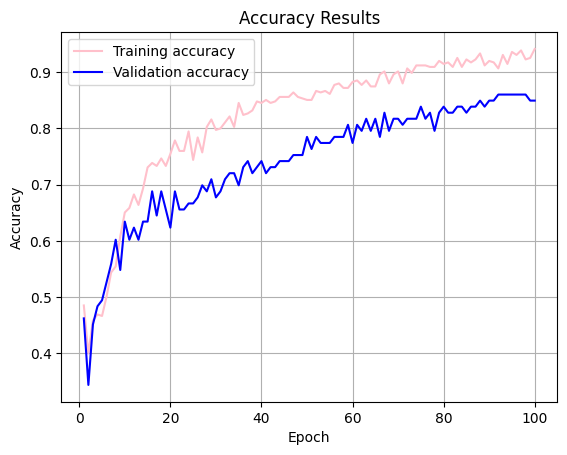

In [13]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)
 
plt.plot(epochs, acc, '-', label='Training accuracy', color = 'pink')
plt.plot(epochs, val_acc, '-', label='Validation accuracy', color = 'blue')
plt.title('Accuracy Results')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()

## Evaluation

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 637us/step


Text(113.9222222222222, 0.5, 'Actual label')

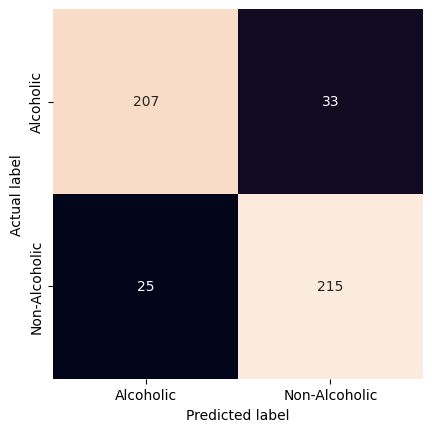

In [14]:
y_predicted = model.predict(test_data) > 0.5
mat = confusion_matrix(test_target, y_predicted)
labels = ['Alcoholic', 'Non-Alcoholic']
 
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, 
            xticklabels=labels, yticklabels=labels)
 
plt.xlabel('Predicted label')
plt.ylabel('Actual label')